In [1]:
%matplotlib inline
from math import pi
import openmc
import openmc.deplete
import matplotlib.pyplot as plt

Let's use the same material definition as the existing pincell depletion example 

In [2]:
# Instantiate some Materials and register the appropriate Nuclides
uo2 = openmc.Material(name='UO2 fuel at 2.4% wt enrichment')
uo2.set_density('g/cm3', 10.29769)
uo2.add_element('U', 1., enrichment=2.4)
uo2.add_element('O', 2.)

helium = openmc.Material(name='Helium for gap')
helium.set_density('g/cm3', 0.001598)
helium.add_element('He', 2.4044e-4)

zircaloy = openmc.Material(name='Zircaloy 4')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_element('Sn', 0.014, 'wo')
zircaloy.add_element('Fe', 0.00165, 'wo')
zircaloy.add_element('Cr', 0.001, 'wo')
zircaloy.add_element('Zr', 0.98335, 'wo')

borated_water = openmc.Material(name='Borated water')
borated_water.set_density('g/cm3', 0.740582)
borated_water.add_element('B', 4.0e-5)
borated_water.add_element('H', 5.0e-2)
borated_water.add_element('O', 2.4e-2)
borated_water.add_s_alpha_beta('c_H_in_H2O')

The geometry definition is going to be slightly different. First, we want to bound the pincell assigning a height. Second, we want to define a cell that contains a universe made of water and helium separated by an interface, which we can initially set at 0 cm. Filling the "msr" cell with a universe is the requirement to use the msr batchwise geometrical scheme as we will see later on.    

In [49]:
# Define surfaces
width = 1.25984
height = 200
fuel_or = openmc.ZCylinder(r=0.39218, name='Fuel OR')
clad_ir = openmc.ZCylinder(r=0.40005, name='Clad IR')
clad_or = openmc.ZCylinder(r=0.45720, name='Clad OR')
wat_or = openmc.ZCylinder(r=width/2, name='H2O OR', boundary_type='reflective')
interface = openmc.ZPlane(z0=0, name='IF')
z_top = openmc.ZPlane(z0=height/2, name='Pin TOP', boundary_type='vacuum')
z_bot = openmc.ZPlane(z0=-height/2, name='Pin BOT', boundary_type='vacuum')

# Define cells
fuel = openmc.Cell(fill=uo2, region=-fuel_or & -z_top & +z_bot)
gap = openmc.Cell(fill=helium, region=+fuel_or & -clad_ir & -z_top & +z_bot)
clad = openmc.Cell(fill=zircaloy, region=+clad_ir & -clad_or & -z_top & +z_bot)
water = openmc.Cell(fill=borated_water, region=+clad_or & -interface )
gas = openmc.Cell(fill=helium, region=+clad_or & +interface)
msr_uni = openmc.Universe(cells=(water, gas))
msr = openmc.Cell(name="MSR", fill=msr_uni, region=-wat_or & -z_top & +z_bot)
# Define overall geometry
geometry = openmc.Geometry([fuel, gap, clad, msr])

In [50]:
# Set material volume for depletion. For 2D simulations, this should be an area.
uo2.volume = pi * fuel_or.r**2

In [51]:
# Instantiate a Settings object, set all runtime parameters, and export to XML
settings = openmc.Settings()
settings.batches = 100
settings.inactive = 10
settings.particles = 1000

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-0.62992, -0.62992, -100, 0.62992, 0.62992, 100]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings.source = openmc.source.Source(space=uniform_dist)

Let's build the mdoel and the plot the pincell. We noticed the interface between the water and helium cell set in the centre point.

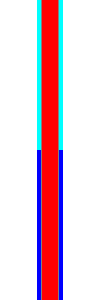

In [62]:
model = openmc.Model(geometry=geometry, settings=settings)
plot = openmc.Plot.from_geometry(geometry)
plot.basis = 'xz'
plot.width = (5,200)
plot.pixels = (100,300)
plot.color_by = 'material'
plot.colors = {uo2:'red', helium:'cyan', borated_water: 'blue', zircaloy: 'gray'}
openmc.plot_inline(plot)

Let's now build and run a standard depletion calculation, same as what was done in the pincell depletion example. The results will be uses as the reference to compare with the MSR capabilities:

In [25]:
#Create depletion "operator"
chain_file = 'chain_simple.xml'
op = openmc.deplete.CoupledOperator(model, chain_file)
# Perform simulation using the predictor algorithm
time_steps = [1.0, 1.0, 1.0, 1.0, 1.0]  # days
power = 174  # W/cm, for 2D simulations only (use W for 3D)
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, timestep_units='d')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading B11 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/B11.h5
 Reading H1 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/H1.h5
 Reading H2 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/H2.h5
 Reading c_H_in_H2O from
 /home/lorenzo/Documents/cross_sections/endfb80_hdf5/c_H_in_H2O.h5
 Minimum neutron data temperature: 294 K
 Maximum neutron data temperature: 294 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400.0 s, source=174
 Reading I135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd157.h5
 Reading Gd156 from /home/lorenzo/Documents/cross_

       28/1    1.19705    1.14108 +/- 0.00716
       29/1    1.08472    1.13812 +/- 0.00740
       30/1    1.13398    1.13791 +/- 0.00702
       31/1    1.09815    1.13602 +/- 0.00694
       32/1    1.17103    1.13761 +/- 0.00681
       33/1    1.10364    1.13613 +/- 0.00667
       34/1    1.10777    1.13495 +/- 0.00649
       35/1    1.08612    1.13300 +/- 0.00653
       36/1    1.18505    1.13500 +/- 0.00658
       37/1    1.13282    1.13492 +/- 0.00634
       38/1    1.12805    1.13467 +/- 0.00611
       39/1    1.15822    1.13548 +/- 0.00595
       40/1    1.15507    1.13614 +/- 0.00579
       41/1    1.18559    1.13773 +/- 0.00582
       42/1    1.11935    1.13716 +/- 0.00566
       43/1    1.17991    1.13845 +/- 0.00564
       44/1    1.12795    1.13814 +/- 0.00548
       45/1    1.22186    1.14054 +/- 0.00583
       46/1    1.17525    1.14150 +/- 0.00575
       47/1    1.15886    1.14197 +/- 0.00561
       48/1    1.15984    1.14244 +/- 0.00548
       49/1    1.09871    1.14132 

       81/1    1.13813    1.12593 +/- 0.00537
       82/1    1.08298    1.12533 +/- 0.00533
       83/1    1.21699    1.12659 +/- 0.00540
       84/1    1.19348    1.12749 +/- 0.00541
       85/1    1.13266    1.12756 +/- 0.00534
       86/1    1.12703    1.12755 +/- 0.00526
       87/1    1.09479    1.12713 +/- 0.00521
       88/1    1.06803    1.12637 +/- 0.00520
       89/1    1.15339    1.12671 +/- 0.00515
       90/1    1.03137    1.12552 +/- 0.00522
       91/1    1.17464    1.12613 +/- 0.00519
       92/1    1.11500    1.12599 +/- 0.00513
       93/1    1.13674    1.12612 +/- 0.00507
       94/1    1.13112    1.12618 +/- 0.00501
       95/1    1.09626    1.12583 +/- 0.00496
       96/1    1.06732    1.12515 +/- 0.00495
       97/1    1.15930    1.12554 +/- 0.00491
       98/1    1.15577    1.12588 +/- 0.00486
       99/1    1.12676    1.12589 +/- 0.00481
      100/1    1.17176    1.12640 +/- 0.00478
 Creating state point statepoint.100.h5...

 =======================>     TIMING

[openmc.deplete] t=345600.0 s, dt=86400.0 s, source=174
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.77508
        2/1    1.00973
        3/1    1.05429
        4/1    1.08611
        5/1    1.07922
        6/1    1.08781
        7/1    1.11079
        8/1    1.20985
        9/1    1.17860
       10/1    1.15704
       11/1    1.13544
       12/1    1.06672    1.10108 +/- 0.03436
       13/1    1.10667    1.10294 +/- 0.01993
       14/1    1.11156    1.10510 +/- 0.01425
       15/1    1.13742    1.11156 +/- 0.01279
       16/1    1.08459    1.10707 +/- 0.01137
       17/1    1.12387    1.10947 +/- 0.00991
       18/1    1.08171    1.10600 +/- 0.00925
       19/1    1.23002    1.11978 +/- 0.01602
       20/1    1.08151    1.11595 +/- 0.01483
       21/1    1.04442 

       54/1    1.16893    1.12035 +/- 0.00599
       55/1    1.13522    1.12068 +/- 0.00586
       56/1    1.12197    1.12071 +/- 0.00574
       57/1    1.14407    1.12121 +/- 0.00563
       58/1    1.18099    1.12245 +/- 0.00565
       59/1    1.10453    1.12209 +/- 0.00555
       60/1    1.09847    1.12161 +/- 0.00546
       61/1    1.11373    1.12146 +/- 0.00535
       62/1    1.08732    1.12080 +/- 0.00529
       63/1    1.13455    1.12106 +/- 0.00520
       64/1    1.00776    1.11896 +/- 0.00551
       65/1    1.14316    1.11940 +/- 0.00543
       66/1    1.16690    1.12025 +/- 0.00540
       67/1    1.12204    1.12028 +/- 0.00530
       68/1    1.10266    1.11998 +/- 0.00522
       69/1    1.21101    1.12152 +/- 0.00536
       70/1    1.07393    1.12073 +/- 0.00533
       71/1    1.03793    1.11937 +/- 0.00541
       72/1    1.20229    1.12071 +/- 0.00549
       73/1    1.12248    1.12074 +/- 0.00540
       74/1    1.13521    1.12096 +/- 0.00532
       75/1    1.11817    1.12092 

We can now analazie the depletion results

In [26]:
# Open results file
results = openmc.deplete.Results("depletion_results.h5")

# Obtain K_eff as a function of time
time, keff = results.get_keff(time_units='d')

# Obtain U235 concentration as a function of time
_, n_U235 = results.get_atoms(uo2, 'U235')

# Obtain Xe135 capture reaction rate as a function of time
_, Xe_capture = results.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')

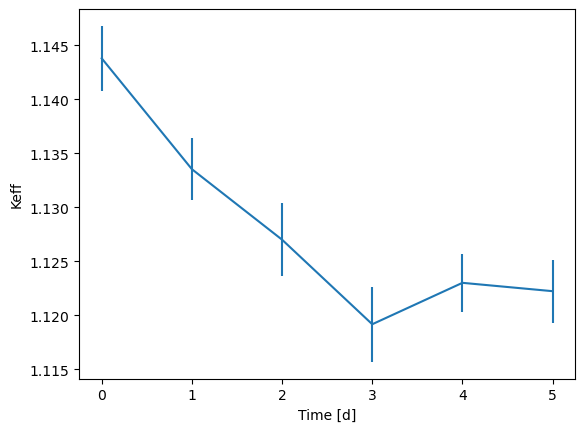

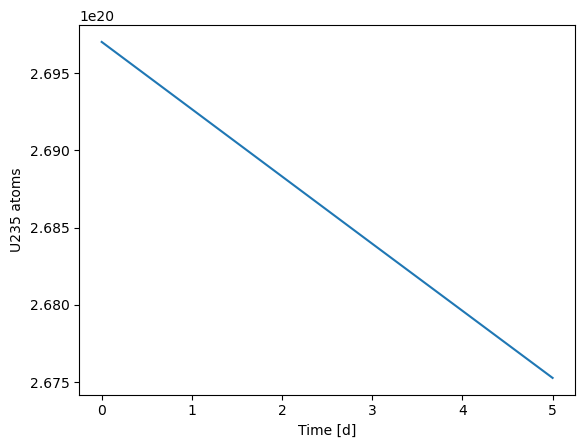

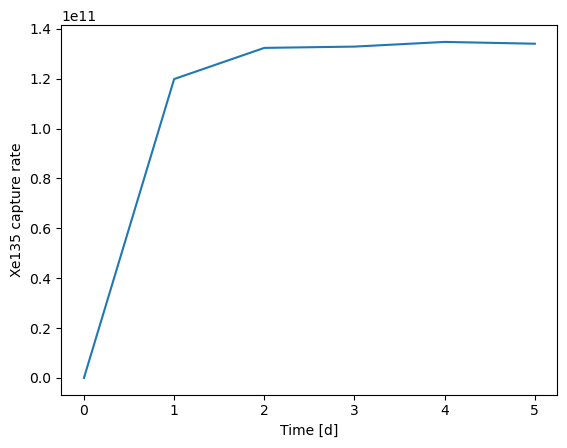

In [27]:
fig, ax = plt.subplots()
ax.errorbar(time, keff[:, 0], keff[:, 1], label="K-effective")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Keff")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, n_U235, label="U235")
ax.set_xlabel("Time [d]")
ax.set_ylabel("U235 atoms")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, Xe_capture, label="Xe135 capture")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Xe135 capture rate")
plt.show()

Let's now introduce the concept of `continuous removal rate` at which some nuclides/elements get removed from the materials, as an additional proportional term to the Bateman equations. This concept assumes first-order removal and homegeneous distributions of the fission products (or elements to removed) throughout the material.

$ \frac{dn_i(t)}{dt} = \underbrace{\sum_j \gamma_{j\rightarrow i} n_j\overline{\sigma_j\phi} - n_i \overline{\sigma_i \phi}}_\textbf{R}  + \underbrace{\sum_j \gamma_{j\rightarrow i} n_j\lambda_{i\rightarrow j} + \lambda_{j\rightarrow i}n_i}_\textbf{D} - \underbrace{\epsilon_i \lambda_i n_i}_\textbf{T}$

Where $ \epsilon_i \lambda_i n_i $ is the removal term, and:

- $\epsilon_i$ is the removal efficiency 

- $\lambda_i$ is the removal rate coefficient for the continuous removal of the nuclide $i$ in ($s^{-1}$)

Another way to characterize $\lambda_i$ is through the concept of cycle time:

$T_{cyc,i} = \frac{1}{\lambda_i}$, as the time needed to process the removal elements at a specific volumetric rate. 

Thus, a new depletion matrix can be built as: 

$\frac{d\vec{n}}{dt} = \underbrace{(\textbf{R+D-T})}_\textbf{A}\vec{n} $, where
- $\textbf{R}$ is the reaction rate term
- $\textbf{D}$ is the decay rate term 
- $\textbf{T}$ is the removal rate or transfer term 

That can be solved in a similar fashion. 

Back to our case, for sake of example, let's set a removal rate of $0.1 (s^{-1})$ for `Xenon` and re-run the the depletion model. 
To do it, we need to instantiate a `openmc.deplete.msr.MsrContinuous` object first, and use the `set_removal_rate` function to set a removal rate to a list of elements (only Xe in this case) and the depletable material to remove from. Lastly, we need to pass our instance to the integrator object.    

In [55]:
# Re-create the depletion "operator"
op = openmc.deplete.CoupledOperator(model, chain_file)
#Create msr continuous instance
msr_c = openmc.deplete.msr.MsrContinuous(op, model)
# Set removal rate from UO2 for Xe. Default units is [sec-1]
msr_c.set_removal_rate('UO2 fuel at 2.4% wt enrichment', ['Xe'], 0.1)
# Pass the msr instance to the integrator object
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, msr_continuous=msr_c,  timestep_units='d')
integrator.integrate()

[openmc.deplete] t=0.0 s, dt=86400.0 s, source=174
 Reading I135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd157.h5
 Reading Gd156 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd156.h5
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0.78105
        2/1    0.91033
        3/1    1.10138
        4/1    1.09109
        5/1    1.11731
        6/1    1.18094
        7/1    1.02980
        8/1    1.15243
        9/1    1.24918
    

       44/1    1.13281    1.14559 +/- 0.00862
       45/1    1.10464    1.14442 +/- 0.00845
       46/1    1.05334    1.14189 +/- 0.00859
       47/1    1.18540    1.14307 +/- 0.00844
       48/1    1.17984    1.14403 +/- 0.00827
       49/1    1.17201    1.14475 +/- 0.00809
       50/1    1.20707    1.14631 +/- 0.00804
       51/1    1.18588    1.14727 +/- 0.00790
       52/1    1.12094    1.14665 +/- 0.00773
       53/1    1.13524    1.14638 +/- 0.00756
       54/1    1.18410    1.14724 +/- 0.00743
       55/1    1.08007    1.14575 +/- 0.00742
       56/1    1.13700    1.14556 +/- 0.00726
       57/1    1.12469    1.14511 +/- 0.00711
       58/1    1.14201    1.14505 +/- 0.00696
       59/1    1.16477    1.14545 +/- 0.00683
       60/1    1.11775    1.14490 +/- 0.00672
       61/1    1.19181    1.14582 +/- 0.00665
       62/1    1.15755    1.14604 +/- 0.00652
       63/1    1.20386    1.14713 +/- 0.00649
       64/1    1.17484    1.14765 +/- 0.00639
       65/1    1.15797    1.14783 

       93/1    1.11731    1.14348 +/- 0.00499
       94/1    1.11894    1.14319 +/- 0.00494
       95/1    1.07259    1.14236 +/- 0.00495
       96/1    1.13581    1.14228 +/- 0.00489
       97/1    1.20495    1.14300 +/- 0.00489
       98/1    1.14746    1.14305 +/- 0.00484
       99/1    1.16233    1.14327 +/- 0.00479
      100/1    1.11576    1.14297 +/- 0.00474
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 0.0000e+00 seconds
   Reading cross sections          = 0.0000e+00 seconds
 Total time in simulation          = 2.7409e+00 seconds
   Time in transport only          = 2.6208e+00 seconds
   Time in inactive batches        = 1.4963e-01 seconds
   Time in active batches          = 2.5913e+00 seconds
   Time synchronizing fission bank = 9.2417e-03 seconds
     Sampling source sites         = 7.8146e-03 seconds
     SEND/RECV source sites        = 1.3647e-03 seconds
   Tim

       12/1    1.19072    1.13341 +/- 0.05731
       13/1    1.07845    1.11509 +/- 0.03782
       14/1    1.20510    1.13759 +/- 0.03495
       15/1    1.16500    1.14307 +/- 0.02762
       16/1    1.11647    1.13864 +/- 0.02299
       17/1    1.15740    1.14132 +/- 0.01961
       18/1    1.18515    1.14680 +/- 0.01784
       19/1    1.09369    1.14090 +/- 0.01681
       20/1    1.08730    1.13554 +/- 0.01596
       21/1    1.10171    1.13246 +/- 0.01476
       22/1    1.16738    1.13537 +/- 0.01378
       23/1    1.19282    1.13979 +/- 0.01343
       24/1    1.16288    1.14144 +/- 0.01254
       25/1    1.13362    1.14092 +/- 0.01169
       26/1    1.14088    1.14092 +/- 0.01093
       27/1    1.18882    1.14373 +/- 0.01065
       28/1    1.17944    1.14572 +/- 0.01023
       29/1    1.09745    1.14318 +/- 0.01001
       30/1    1.10317    1.14118 +/- 0.00970
       31/1    1.07152    1.13786 +/- 0.00981
       32/1    1.16191    1.13895 +/- 0.00941
       33/1    1.16413    1.14005 

       66/1    1.14923    1.14237 +/- 0.00523
       67/1    1.09502    1.14154 +/- 0.00520
       68/1    1.14382    1.14158 +/- 0.00511
       69/1    1.10176    1.14090 +/- 0.00507
       70/1    1.16164    1.14125 +/- 0.00499
       71/1    1.14886    1.14137 +/- 0.00491
       72/1    1.15291    1.14156 +/- 0.00484
       73/1    1.09401    1.14080 +/- 0.00482
       74/1    1.17010    1.14126 +/- 0.00477
       75/1    1.18266    1.14190 +/- 0.00473
       76/1    1.11192    1.14144 +/- 0.00468
       77/1    1.14727    1.14153 +/- 0.00462
       78/1    1.16645    1.14190 +/- 0.00456
       79/1    1.13671    1.14182 +/- 0.00450
       80/1    1.14323    1.14184 +/- 0.00443
       81/1    1.12293    1.14158 +/- 0.00438
       82/1    1.16426    1.14189 +/- 0.00433
       83/1    1.11066    1.14146 +/- 0.00429
       84/1    1.16198    1.14174 +/- 0.00424
       85/1    1.18853    1.14236 +/- 0.00423
       86/1    1.09950    1.14180 +/- 0.00421
       87/1    1.14172    1.14180 

Let's open the results and plot them again:

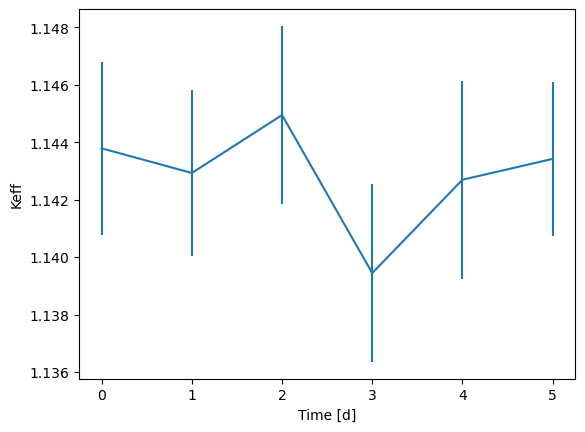

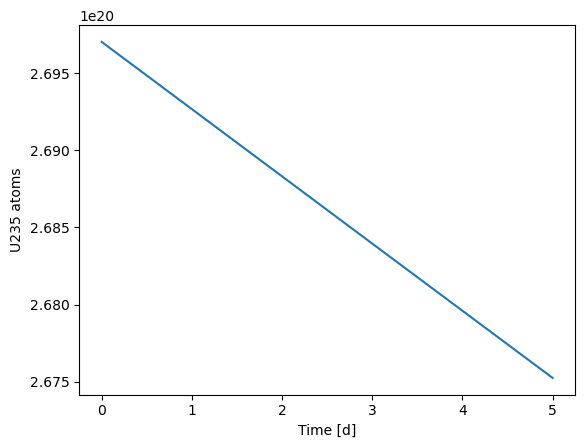

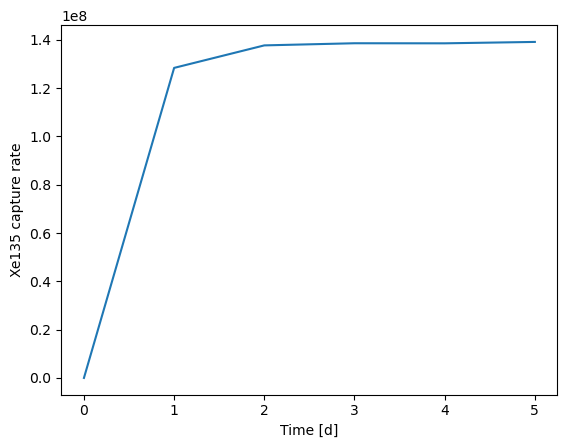

In [56]:
results = openmc.deplete.Results("depletion_results.h5")
time, keff = results.get_keff(time_units='d')
_, n_U235 = results.get_atoms(uo2, 'U235')
_, Xe_capture = results.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')

fig, ax = plt.subplots()
ax.errorbar(time, keff[:, 0], keff[:, 1], label="K-effective")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Keff")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, n_U235, label="U235")
ax.set_xlabel("Time [d]")
ax.set_ylabel("U235 atoms")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, Xe_capture, label="Xe135 capture")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Xe135 capture rate")
plt.show()

As we can, `Xe135` capture has reduced indicating that the removal has worked, and consequently `keff` is almost kept constant. 

Let's now show the capability of the `batchwise`control instead. We now want to apply some single actions in time to the system to fulfill some objectives, such as maintain a ceratin level of criticality. The current implementation allow the user to defined `geometry-based`or `material-based`actions. 

If we get back to our example, let's assume we want to maintain keff close to its initial value $(\sim 1.145 )$ during the whole depletion time, by dynamically increase the quantity of borated water that acts as a moderator and should compensate for the capture of the fission products build-up. The msr cell previously defined, and should now be clear the purpose of having it filled with a universe containing borated water and helium gas, can be translated so to shift the interface up, i.e. increasing the volume of the borated water with respect to the inhert gas. 

Here we need to instantiate  `openmc.deplete.msr.MsrBatchwiseGeom` object instead, and set it up with the relevant arguments:
- axis=2 : we want the cell translation on the z-axis
- bracket=[-2,2]: we want to limit the `search_for_keff` to $\pm2 cm $ from the initial or previous iteration value. 
- bracket_limit=[-100,100] : this sets the limit of the `search_for_keff` to our pincell height 
- tol=0.01 : `search_for_keff` tolerance 
- target=1.145 : `search_for_keff` target 


In [57]:
# Re-create the depletion "operator"
op = openmc.deplete.CoupledOperator(model, chain_file)
#Create msr batchwise geometrical instance
msr_g = openmc.deplete.msr.MsrBatchwiseGeom(op, model, cell_id_or_name = 'MSR',
                axis=2, bracket=[-2,2], bracket_limit=[-100,100], tol=0.01, target=1.145)
# Pass the msr instance to the integrator object
integrator = openmc.deplete.PredictorIntegrator(op, time_steps, power, msr_batchwise=msr_g,  timestep_units='d')
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400.0 s, source=174
 Reading I135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd157.h5
 Reading Gd156 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd156.h5
 Maximum neutron transport energy: 20000000 eV for O17
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k            Average k
  =========   ========   ====================
        1/1    0

Iteration: 3; Guess of 3.38e+01 produced a keff of 1.14548 +/- 0.00281
Iteration: 4; Guess of 3.18e+01 produced a keff of 1.13993 +/- 0.00324
Iteration: 5; Guess of 3.37e+01 produced a keff of 1.13984 +/- 0.00342
UPDATE: old value: 0.00 cm --> new value: 33.85 cm
33.84837648178612
Timestep: 1 --> keff: 1.14250
[openmc.deplete] t=172800.0 s, dt=86400.0 s, source=174
Iteration: 1; Guess of 3.18e+01 produced a keff of 1.14265 +/- 0.00302
Iteration: 2; Guess of 3.58e+01 produced a keff of 1.14566 +/- 0.00372
Iteration: 3; Guess of 3.50e+01 produced a keff of 1.14264 +/- 0.00301
Iteration: 4; Guess of 3.57e+01 produced a keff of 1.14369 +/- 0.00273
Iteration: 5; Guess of 3.58e+01 produced a keff of 1.14795 +/- 0.00290
Iteration: 6; Guess of 3.57e+01 produced a keff of 1.14465 +/- 0.00293
Iteration: 7; Guess of 3.57e+01 produced a keff of 1.14323 +/- 0.00317
Iteration: 8; Guess of 3.57e+01 produced a keff of 1.14798 +/- 0.00303
Iteration: 9; Guess of 3.57e+01 produced a keff of 1.14725 +/- 0

Again, let's analyse the results:

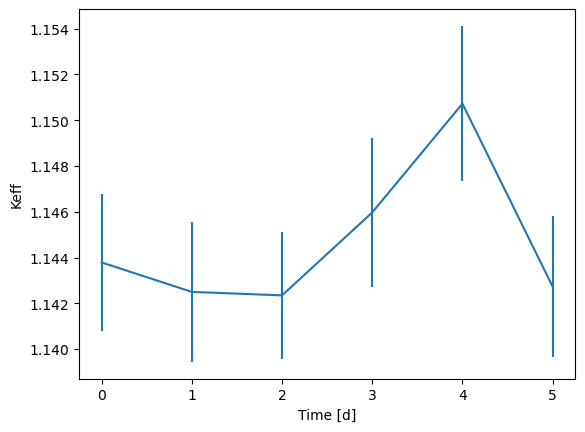

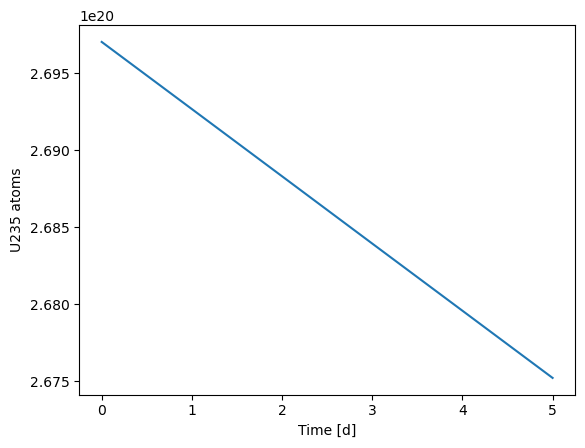

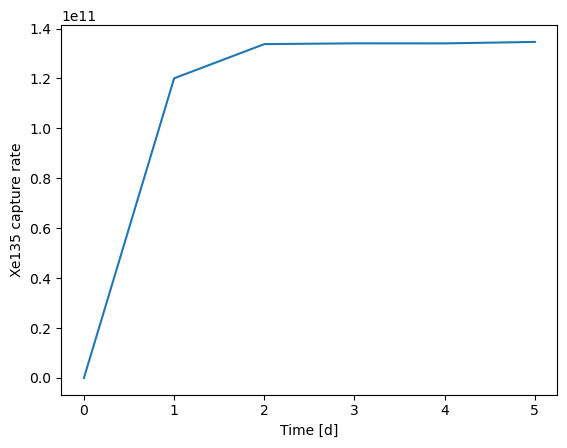

In [58]:
results = openmc.deplete.Results("depletion_results.h5")
time, keff = results.get_keff(time_units='d')
_, n_U235 = results.get_atoms(uo2, 'U235')
_, Xe_capture = results.get_reaction_rate(uo2, 'Xe135', '(n,gamma)')

fig, ax = plt.subplots()
ax.errorbar(time, keff[:, 0], keff[:, 1], label="K-effective")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Keff")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, n_U235, label="U235")
ax.set_xlabel("Time [d]")
ax.set_ylabel("U235 atoms")
plt.show()

fig, ax = plt.subplots()
ax.plot(time, Xe_capture, label="Xe135 capture")
ax.set_xlabel("Time [d]")
ax.set_ylabel("Xe135 capture rate")
plt.show()

As we can notice, `keff` is maintained even though the `Xe135`(main absorber) production has the same rate as the initial case, and this is achieved through the water level raising. 